# Importing Libraries

Description: As I didnot have enough RAM to load all the dataset, I was only able to perform computation on the first 10000 rows of the first dataset out of six.
I will be really pleased if the judge would check my accuracy individually and not compare it with others who have better RAMs installed.

In [1]:
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa 
from pyarrow.parquet import ParquetFile

# Path to the parquet file
file_path = '/kaggle/input/datsat/top_gun_opendata_0.parquet'

# Read the Parquet file
num_rows = pq.read_metadata(file_path).num_rows
print(num_rows)
# Read the first half of the Parquet file
pf = ParquetFile('/kaggle/input/datsat/top_gun_opendata_0.parquet') 
first_ten_rows = next(pf.iter_batches(batch_size = 10000)) 
df = pa.Table.from_batches([first_ten_rows]).to_pandas() 
# Print the DataFrame
df

150327


,X_jet,m,iphi,pt,ieta
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",291.988312,33.0,962.311523,16.0
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",466.154877,48.0,555.076416,36.0
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",451.912231,0.0,434.385803,19.0
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",393.327454,40.0,418.650391,21.0
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",180.342300,19.0,985.945129,16.0
...,...,...,...,...,...
9995,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",351.958557,28.0,906.086670,20.0
9996,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",323.185333,19.0,400.424225,15.0
9997,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",327.438812,49.0,704.295532,39.0
9998,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",437.665192,12.0,464.536072,32.0


# Formatting and Splitting Data

In [4]:
X_train=[]
for data in df['X_jet']:
    val = np.zeros((125,125,3))
    val[:,:,0]= list(data[0])
    val[:,:,1]= list(data[3])
    val[:,:,2]= list(data[1])
    X_train.append([np.copy(val)])
X_train = [x[0] for x in X_train]
X_train = np.array(X_train)
X_test = X_train[8000:]
X_train = X_train[:8000]
Y = df['m']
Y_test = Y[8000:]
Y_train = Y[:8000]


# Visualization of the three channels

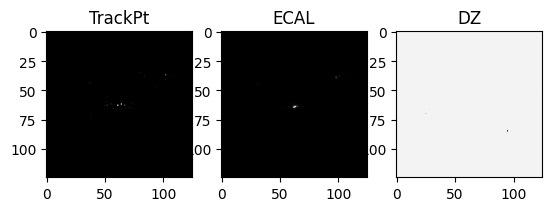

In [7]:
import matplotlib.pyplot as plt
import numpy as np  # assuming you've imported numpy

fig, ax = plt.subplots(1,3)
ax[0].imshow(X_train[0,:,:,0], cmap='gray')
ax[0].set_title('TrackPt')
ax[1].imshow(X_train[0,:,:,1], cmap='gray')
ax[1].set_title('ECAL')
ax[2].imshow(X_train[0,:,:,2], cmap='gray')
ax[2].set_title('DZ')
plt.show()


# EfficientNet Implementation

In [53]:
import torch
import torchvision.models as models
import torch.nn as nn

class E2EModel(nn.Module):
    def __init__(self):
        super(E2EModel, self).__init__()
        self.channel1= models.efficientnet_b0(pretrained=True)
        self.channel1.classifier[1] = nn.Linear(1280,500)
        self.final = nn.Linear(500,1)
    def forward(self,x):
        output1 = self.channel1(x)
        output = self.final(output1)
        return output
# Load pre-trained EfficientNet-B0
model = E2EModel()
# Print the model


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training the model

In [54]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch import optim

transform = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MyDataset(Dataset):
    def __init__(self, X_train,y, transform=None):
        self.transform = transform
        self.df = df
        self.X = X_train
        self.Y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        
        label = self.Y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Now you can use your custom dataset
trainset = MyDataset(X_train,Y_train, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
model = model.to(device)  # Move model to GPU if available

# Initialize optimizer
optimizer = optim.Adam(model.parameters())

# Initialize loss function
loss_fn = nn.MSELoss()

# Number of epochs
num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss = 0  # Initialize loss for this epoch
    num_batches = 0 
    for i, data in enumerate(trainloader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs = data[0].float().to(device)
        label = data[1].float().to(device)
         # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze(1)  # This will change the shape from [40, 1] to [40]

        # Compute loss
        loss = loss_fn(outputs,label)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1
        # Print statistics
    print(f'Loss at the end of epoch {epoch+1}: {epoch_loss/num_batches}')


Loss at the end of epoch 1: 22022.4250078125
Loss at the end of epoch 2: 9574.8254453125
Loss at the end of epoch 3: 8514.6040625
Loss at the end of epoch 4: 7729.8505546875
Loss at the end of epoch 5: 7128.15035546875
Loss at the end of epoch 6: 6346.367015625
Loss at the end of epoch 7: 5752.9914453125
Loss at the end of epoch 8: 5111.805760742188
Loss at the end of epoch 9: 4505.50558984375
Loss at the end of epoch 10: 3952.580875
Loss at the end of epoch 11: 3509.00126171875
Loss at the end of epoch 12: 3147.5509111328124
Loss at the end of epoch 13: 2879.2652626953127
Loss at the end of epoch 14: 2723.7088056640623
Loss at the end of epoch 15: 2567.1792822265625
Loss at the end of epoch 16: 1945.57934765625
Loss at the end of epoch 17: 1915.959046875
Loss at the end of epoch 18: 1839.2395146484375
Loss at the end of epoch 19: 1734.22871484375
Loss at the end of epoch 20: 1467.5809809570312
Loss at the end of epoch 21: 1584.8919399414062
Loss at the end of epoch 22: 1669.4611948242

# Testing Model

In [55]:
class MyDataset1(Dataset):
    def __init__(self, X_test,Y_test, transform=None):
        self.transform = transform
        self.X = X_test
        self.Y = Y_test

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        
        label = self.Y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Now you can use your custom dataset
testset = MyDataset1(X_test,df1, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Initialize a list to store the model's predictions
predictions = []

# Initialize a list to store the true labels
true_labels = []

# Set the model to evaluation mode
model.eval()

# No need to track gradients in test mode
with torch.no_grad():
    for data in testloader:
        # Get the inputs; data is a list of [inputs, labels]
        inputs = data[0].float().to(device)
        labels = data[1].float().to(device)

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze(1)  # This will change the shape from [40, 1] to [40]

        # Store the model's predictions
        predictions.extend(outputs.tolist())

        # Store the true labels
        true_labels.extend(labels.tolist())



In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


mae = mean_absolute_error(df1,predictions)
mse = mean_squared_error(df1,predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 125.69911757278443
Mean Squared Error (MSE): 23534.958244799964
Root Mean Squared Error (RMSE): 153.41107601734618


In [57]:
# Save the entire model

# Save only the model parameters (recommended)
torch.save(model.state_dict(), 'regressionparams.pth')


# Another MultiLayer Implementation that didnt work

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN model with three channels
class MultiChannelCNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(MultiChannelCNN, self).__init__()
        self.conv1_channel1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv1_channel2 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv1_channel3 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        
        self.conv2_channel1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv2_channel2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv2_channel3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        self.conv3_channel1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv3_channel2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv3_channel3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        
        self.fc_channel1 = nn.Linear(64 * 27 * 27, 64)
        self.fc_channel2 = nn.Linear(64 * 27 * 27, 64)
        self.fc_channel3 = nn.Linear(64 * 27 * 27, 64)
        
        self.fc_final1 = nn.Linear(64 * 3, 64)
        self.fc_final2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Forward pass for first channel
        x_channel1 = x[:,0,:,:]
        x_channel2 = x[:,1,:,:]
        x_channel3 = x[:,2,:,:]
        x_channel1 = x_channel1.unsqueeze(1)
        x_channel2 = x_channel2.unsqueeze(1)
        x_channel3 = x_channel3.unsqueeze(1)

        x1 = F.relu(F.max_pool2d(self.conv1_channel1(x_channel1), 2))
        x1 = F.relu(F.max_pool2d(self.conv2_channel1(x1), 2))
        x1 = F.relu(self.conv3_channel1(x1))
        x1 = x1.view(-1, 64 * 27 * 27)  # Flatten
        
        # Forward pass for second channel
        x2 = F.relu(F.max_pool2d(self.conv1_channel2(x_channel2), 2))
        x2 = F.relu(F.max_pool2d(self.conv2_channel2(x2), 2))
        x2 = F.relu(self.conv3_channel2(x2))
        x2 = x2.view(-1, 64 * 27 * 27)  # Flatten
        
        # Forward pass for third channel
        x3 = F.relu(F.max_pool2d(self.conv1_channel3(x_channel3), 2))
        x3 = F.relu(F.max_pool2d(self.conv2_channel3(x3), 2))
        x3 = F.relu(self.conv3_channel3(x3))
        x3 = x3.view(-1, 64 * 27 * 27)  # Flatten
        
        # Fully connected layers for each channel
        x1 = F.relu(self.fc_channel1(x1))
        x2 = F.relu(self.fc_channel2(x2))
        x3 = F.relu(self.fc_channel3(x3))
        
        # Concatenate the outputs from the three channels
        x = torch.cat((x1, x2, x3), dim=1)
        
        # Final fully connected layers for regression
        x = F.relu(self.fc_final1(x))
        x = self.fc_final2(x)
        return x

# Example input shape for 125x125 images with 3 channels
input_shape = (3, 125, 125)
num_classes = 1  # Regression task, so output is a single value

# Create the model
model = MultiChannelCNN(input_shape, num_classes)

# Display model architecture


In this approach I tried to apply computations on all three channels separately and then at end tried to concatenate them to give a final output, Howeverit seems that there was a relation between the channels which was ignored by this implemnetation so it didnt work.